In [1]:
# 8.18 순전파와 역전파 후크 등록

"""Grad-CAM 예제에서는 사전학습된 ResNet-18과 후크(Hook)를 활용해 실습을 진행한다.
   Hook란 특정 이벤트가 발생했을 때 다른 코드를 실행하는 기술을 의미한다.
   Grad-CAM 마지막 합성곱 계층의 순전파와 역전파를 활용하므로 해당 계층이 실행될 때 이벤트를 실행시켜 기울기 값을 받아온다."""

import torch


class GradCAM:
    # 활성화 맵을 받아오려는 모델과 마지막 합성곱 계층을 확인하기 위한 main과 sub를 받아온다.
    # ResNet-18을 기준으로 한다면 마지막 합성곱 계층은 layer4의 conv2 계층이다. 그러므로 main은 layer4, sub는 conv2가 된다.
    def __init__(self, model, main, sub):
        self.model = model.eval()
        self.register_hook(main, sub)

    # 모델의 하위 모듈을 검색 -> main과 sub가 동일한 계층을 찾고 순방향 후크와 역방향 후크를 등록
    def register_hook(self, main, sub):
        for name, module in self.model.named_children(): # 모듈의 이름과 모듈을 반환
            if name == main:
                for sub_name, sub_module in module[-1].named_children():
                    if sub_name == sub:
                        sub_module.register_forward_hook(self.forward_hook)
                        sub_module.register_full_backward_hook(self.backward_hook)

    # 해당 모듈의 순방향 연산이 진행될 때 호출
    def forward_hook(self, module, input, output): # module:입력된 모듈, input:순방향 연산의 입력 데이터, output:순방향 연산의 출력 데이터
        self.feature_map = output  # Grad-CAM은 마지막 계층의 특징맵을 요구하므로 순방향 연산의 출력값(fk(i,j))을 feature_map에 저장

    # 해당 모듈의 backward 메서드가 호출될 때마다 호출
    def backward_hook(self, module, grad_input, grad_output): # grad_input:기울기 입력값, grad_output:기울기 출력값
        self.gradient = grad_output[0] # 기울기 출력값은 튜플로 감싸인 텐서를 갖고 있으므로 첫 번째 텐서만 반환한다.
    
    # 8.19 Grad-CAM 생성
    def __call__(self, x):
        output = self.model(x) #[N,1000]

        index = output.argmax(axis=1) # 출력값에 해당하는 클래스 index를 추출, 출력값은 [N,1000]의 형태를 가지므로 가장 높은 클래스로 할당된 index를 추출, [N,1]
        one_hot = torch.zeros_like(output) # 추출된 색인 값을 활용해 원-핫 인코딩을 적용, 원-핫 인코딩이 적용된 배열에서 최댓값 색인 위치에만 1을 부여, [N,1000]
        for i in range(output.size(0)):
            one_hot[i][index[i]] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True) #하나의 이미지에서 여러 클래스의 Grad-CAM을 보려고 하거나, 역전파 연산이 자주 일어나는 경우 retain_graph=True -> 역전파 연산이 여러 번 일어날 때 발생하는 오류를 억제

        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True) # self.gradient -> [N,512,7,7] 이므로 평균 계산 시 세 번째와 네 번째 차원을 따라 평균을 계산, keepdim=True -> 평균 계산시 차원 유지 (N은 이미지 개수)
        # a_k -> [N,512,1,1]
        grad_cam = torch.sum(a_k * self.feature_map, dim=1) # [N,7,7]
        grad_cam = torch.relu(grad_cam)
        return grad_cam

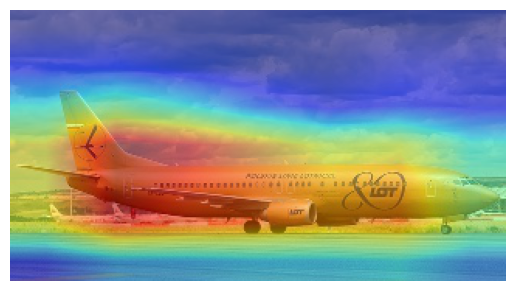

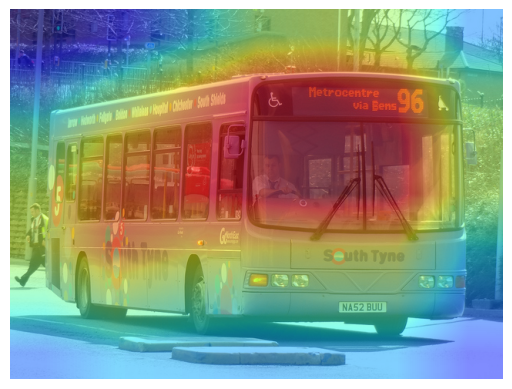

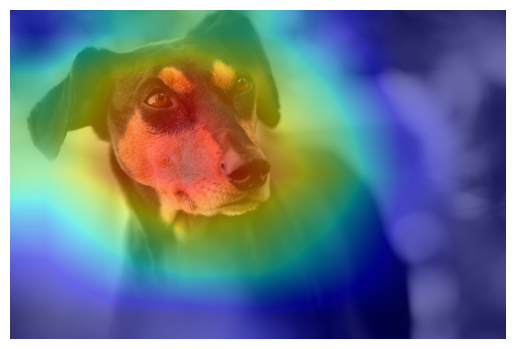

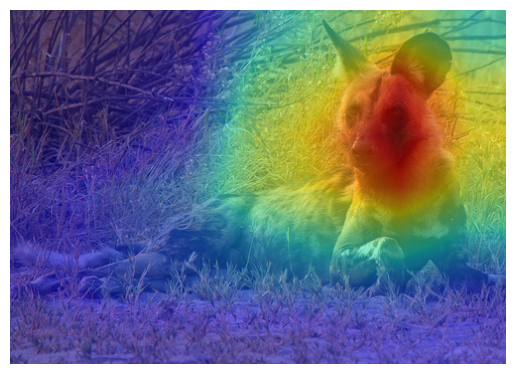

In [4]:
# 8.20 Grad-CAM 시각화

from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

files = [
    "../datasets/images/airplane.jpg", "../datasets/images/bus.jpg",
    "../datasets/images/dog.jpg", "../datasets/images/african_hunting_dog.jpg"
]
images, tensors = [], []
for file in files:
    image = Image.open(file)
    images.append(image)
    tensors.append(transform(image))
tensors = torch.stack(tensors)

model = GradCAM(
    model=models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),
    main="layer4",
    sub="conv2"
)
grad_cams = model(tensors)

for idx, image in enumerate(images):
    # interpolate 함수를 통해 입력 이미지와 동일한 크기로 변경
    grad_cam = F.interpolate(
        input=grad_cams[idx].unsqueeze(0).unsqueeze(0), #[1,1,7,7]
        size=(image.size[1], image.size[0]), #[320,175]
        mode="bilinear",
    ).squeeze().detach().numpy() #[175,320]

    plt.imshow(image)
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()